# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [2]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [3]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [4]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [5]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Metricas de Desempeño

In [6]:
def metrics(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark']
    alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T


---

#### Importación de Datos

In [7]:
tickers = ['PG', 'COST', 'KO', 'WMT', 'CLX', 'K', 'KHC']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

YF.download() has changed argument auto_adjust default to True


In [8]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [9]:
w_minvar = opt_min_var(rets)
w_minvar

array([3.19892243e-18, 1.88151685e-01, 1.02399158e-02, 9.29531899e-02,
       3.13356262e-01, 2.59675787e-01, 1.35623160e-01])

#### Máximo de Sharpe

In [10]:
w_maxsharpe = opt_max_sharpe(rets,0.045)
w_maxsharpe

array([4.90511310e-18, 7.96318551e-01, 0.00000000e+00, 0.00000000e+00,
       2.61864879e-18, 6.85836513e-02, 1.35097798e-01])

#### Semi Varianza Target

In [11]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'CLX': 0.14285714285714285,
 'COST': 0.14285714285714285,
 'K': 0.14285714285714285,
 'KHC': 0.14285714285714285,
 'KO': 0.14285714285714285,
 'PG': 0.14285714285714285,
 'WMT': 0.14285714285714285}

#### Backtesting

In [12]:
capital = 1000000

In [13]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Benchmark': 1
}

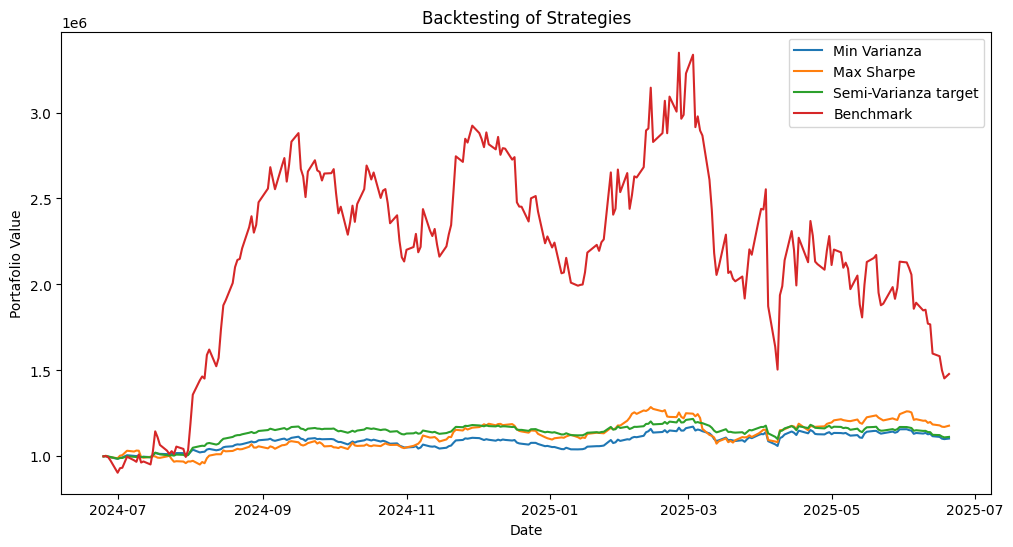

In [14]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

In [15]:
metricas = metrics(history, 0.045)
metricas

,Min Varianza,Max Sharpe,Semi-Varianza target,Benchmark
Rendimiento Promedio Anual,11.106570,18.893780,11.797807,82.584650
Volatilidad Anual,14.577250,20.741549,13.219403,92.535823
Ratio de Sharpe,0.758824,0.908745,0.889057,0.891975
Downside Risk,9.481208,14.810674,8.438350,59.068452
Upside Risk,9.954782,13.835131,9.238397,64.668782
Omega,1.049949,0.934132,1.094811,1.094811
Beta,0.148877,0.153238,0.142857,1.000000
Ratio de Treynor,74.299963,123.003204,82.269650,82.539650
Ratio de Sortino,1.166684,1.272648,1.392785,1.397356


In [16]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_min_var(rets_bt)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt

,w,Cash,No. Acciones
Ticker,,,
CLX,0.045780,45780.171483,379.0
COST,0.184887,184887.138644,188.0
K,0.327643,327643.053559,4164.0
KHC,0.068202,68201.659435,2643.0
KO,0.291148,291147.853172,4229.0
PG,0.048376,48375.621257,304.0
WMT,0.033965,33964.502449,353.0


---

#### Con diferentes activos

In [17]:
tickers = ['LLY', 'ISRG', 'ABBV', 'JNJ', 'MRK']

In [18]:
opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [19]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()


---

#### Mínima Varianza 

In [20]:
w_minvar = opt_min_var(rets)

#### Máximo de Sharpe

In [21]:
w_maxsharpe = opt_max_sharpe(rets, 0.045)

#### Semi Varianza Target

In [22]:
w_semivar = objetivo(rets, rets_b, corr)

#### Backtesting

##### Capital

In [23]:
capital = 1000000

In [24]:
w_dict= {
    'Min Var' : w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi Var': w_semivar,
    'Benchmark': 1
}

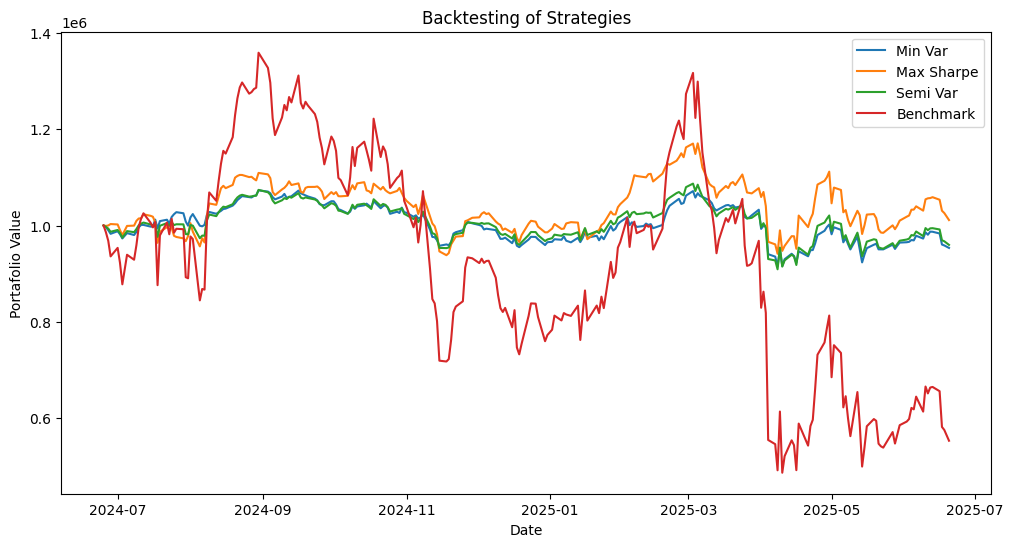

In [25]:
history = backtesting(bt_prices,benchmark, w_dict, capital )

In [26]:
metrics(history, rf= 0.045)


,Min Var,Max Sharpe,Semi Var,Benchmark
Rendimiento Promedio Anual,-3.311041,4.585971,-2.298112,-11.490562
Volatilidad Anual,17.604902,26.242543,19.474770,97.373851
Ratio de Sharpe,-0.190631,0.173039,-0.120315,-0.118467
Downside Risk,14.161074,20.031988,15.183319,75.916595
Upside Risk,9.930763,17.332528,12.534064,62.670319
Omega,0.701272,0.865243,0.825515,0.825515
Beta,0.171365,0.248053,0.200000,1.000000
Ratio de Treynor,-19.584196,18.306427,-11.715562,-11.535562
Ratio de Sortino,-0.236991,0.226686,-0.154321,-0.151950


#### Portafolio Real 

In [29]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_max_sharpe(rets_bt, 0.045)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt['w'].sum()
re_opt

,w,Cash,No. Acciones
Ticker,,,
ABBV,4.111758e-01,4.111758e+05,2218.0
ISRG,5.888242e-01,5.888242e+05,1156.0
JNJ,7.552876e-16,7.552876e-10,0.0
LLY,9.753754e-17,9.753754e-11,0.0
MRK,0.000000e+00,0.000000e+00,0.0


---